# Heston SLV Hedging and P&L Analysis
- example of using CppFM in Python

In [1]:
import cppfm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

print(f"CppFM version: {cppfm.__version__}")

CppFM version: 0.1.0


In [2]:
import sys
print(sys.executable)

/Users/patrikliba/QFB/.venv/bin/python


## 1. Market Data Setup

Define the volatility surface from market implied volatilities.

In [3]:
# Risk-free rate
r = 0.05
curve = cppfm.FlatDiscountCurve(r)

# Spot price
S0 = 100.0

# Market volatility surface data
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]
maturities = [0.08, 0.25, 0.5, 1.0, 2.0]  # 1M, 3M, 6M, 1Y, 2Y

# Implied volatility matrix (skew structure)
# Shape: [len(maturities), len(strikes)]
ivs = [
    [0.28, 0.26, 0.24, 0.22, 0.21, 0.22, 0.24, 0.26, 0.28],  # 1M (high skew)
    [0.26, 0.24, 0.22, 0.21, 0.20, 0.21, 0.22, 0.24, 0.26],  # 3M
    [0.25, 0.23, 0.21, 0.20, 0.19, 0.20, 0.21, 0.23, 0.25],  # 6M
    [0.24, 0.22, 0.20, 0.19, 0.18, 0.19, 0.20, 0.22, 0.24],  # 1Y
    [0.23, 0.21, 0.19, 0.18, 0.17, 0.18, 0.19, 0.21, 0.23],  # 2Y (lower skew)
]

# Create volatility surface
vol_surface = cppfm.VolatilitySurface(
    strikes, maturities, ivs, curve,
    cppfm.SmileInterpolation.CubicSpline,
    cppfm.MaturityInterpolation.ForwardMoneyness
)

print(f"Surface bounds: {vol_surface.get_bounds()}")
print(f"ATM 1Y IV: {vol_surface.implied_volatility(100, 1.0):.2%}")
print(f"Local vol at (S=100, t=0.5): {vol_surface.local_volatility(100, 0.5):.2%}")

Surface bounds: ((80.0, 120.0), (0.08, 2.0))
ATM 1Y IV: 18.00%
Local vol at (S=100, t=0.5): 11.45%


## 2. Heston Model Setup

Create the Heston stochastic volatility model.

In [4]:
# Heston model parameters
v0 = 0.04       # Initial variance (20% vol)
kappa = 2.0     # Mean reversion speed
vbar = 0.04     # Long-term variance
sigma_v = 0.3   # Vol-of-vol
rho = -0.7      # Correlation (negative for equity skew)

heston = cppfm.HestonModel(
    spot=S0,
    discount_curve=curve,
    v0=v0,
    kappa=kappa,
    vbar=vbar,
    sigma_v=sigma_v,
    rho=rho
)

print(heston)
print(f"Feller condition satisfied: {heston.satisfies_feller()}")
print(f"  2*kappa*vbar = {2*kappa*vbar:.4f}")
print(f"  sigma_v^2    = {sigma_v**2:.4f}")

<HestonModel S0=100.000000 v0=0.040000 kappa=2.000000 vbar=0.040000 sigma_v=0.300000 rho=-0.700000>
Feller condition satisfied: True
  2*kappa*vbar = 0.1600
  sigma_v^2    = 0.0900


## 3. Run SLV Simulation

Simulate paths using the Heston SLV model (van der Stoep methodology).

In [5]:
# Simulation parameters
T = 1.0              # 1 year maturity
n_steps = 252        # Daily steps
n_paths = 50000      # Number of MC paths
n_bins = 20          # Bins for E[V|S]
seed = 42

# Time grid
time_steps = list(np.linspace(0, T, n_steps + 1))

# Create simulator
sim = cppfm.HestonSLVSimulator(
    heston, vol_surface, time_steps,
    num_paths=n_paths,
    num_bins=n_bins,
    seed=seed
)

print(f"Running SLV simulation with {n_paths:,} paths...")

start = time.time()

# Get full path history for hedging analysis (uses parallel by default)
paths_full = sim.simulate_full()

elapsed = time.time() - start
print(f"Simulation completed in {elapsed:.2f} seconds")
print(f"Paths shape: {len(paths_full)} paths x {len(paths_full[0])} time steps")

Running SLV simulation with 50,000 paths...
Simulation completed in 2.17 seconds
Paths shape: 50000 paths x 253 time steps


In [6]:
# Parallel (default)
start = time.time()
paths_parallel = sim.simulate_full()  # parallel=True by default
print(f"Parallel: {time.time() - start:.2f}s")

# Sequential (for comparison)
start = time.time()
paths_sequential = sim.simulate_full(parallel=False)
print(f"Sequential: {time.time() - start:.2f}s")

""" NOTE: The fix reuses Z_V for both the quadratic scheme and exponential branch switching. 
For optimal statistical quality, we may want to later modify stepVarianceQE 
to accept two independent random numbers. 
But this works correctly now.

double Z_V = generateStandardNormal();    // for quadratic branch
double Z_u = generateStandardNormal();    // separate random
double U_V = stdNormCdf(Z_u);             // transformed to uniform for exp branch

"""

Parallel: 2.64s
Sequential: 6.77s


## 4. Extract Path Data

Convert to numpy arrays for analysis.

In [7]:
# Convert to numpy arrays
# paths_full[path_idx][time_idx] = (S, V)

n_paths_actual = len(paths_full)
n_times = len(paths_full[0])

spots = np.zeros((n_paths_actual, n_times))
variances = np.zeros((n_paths_actual, n_times))

for i, path in enumerate(paths_full):
    for j, (s, v) in enumerate(path):
        spots[i, j] = s
        variances[i, j] = v

print(f"Spots shape: {spots.shape}")
print(f"Initial spot: {spots[:, 0].mean():.4f} (should be {S0})")
print(f"Terminal spot mean: {spots[:, -1].mean():.4f}")
print(f"Terminal spot std: {spots[:, -1].std():.4f}")

Spots shape: (50000, 253)
Initial spot: 100.0000 (should be 100.0)
Terminal spot mean: 105.1685
Terminal spot std: 21.6562


## 5. Visualize Paths

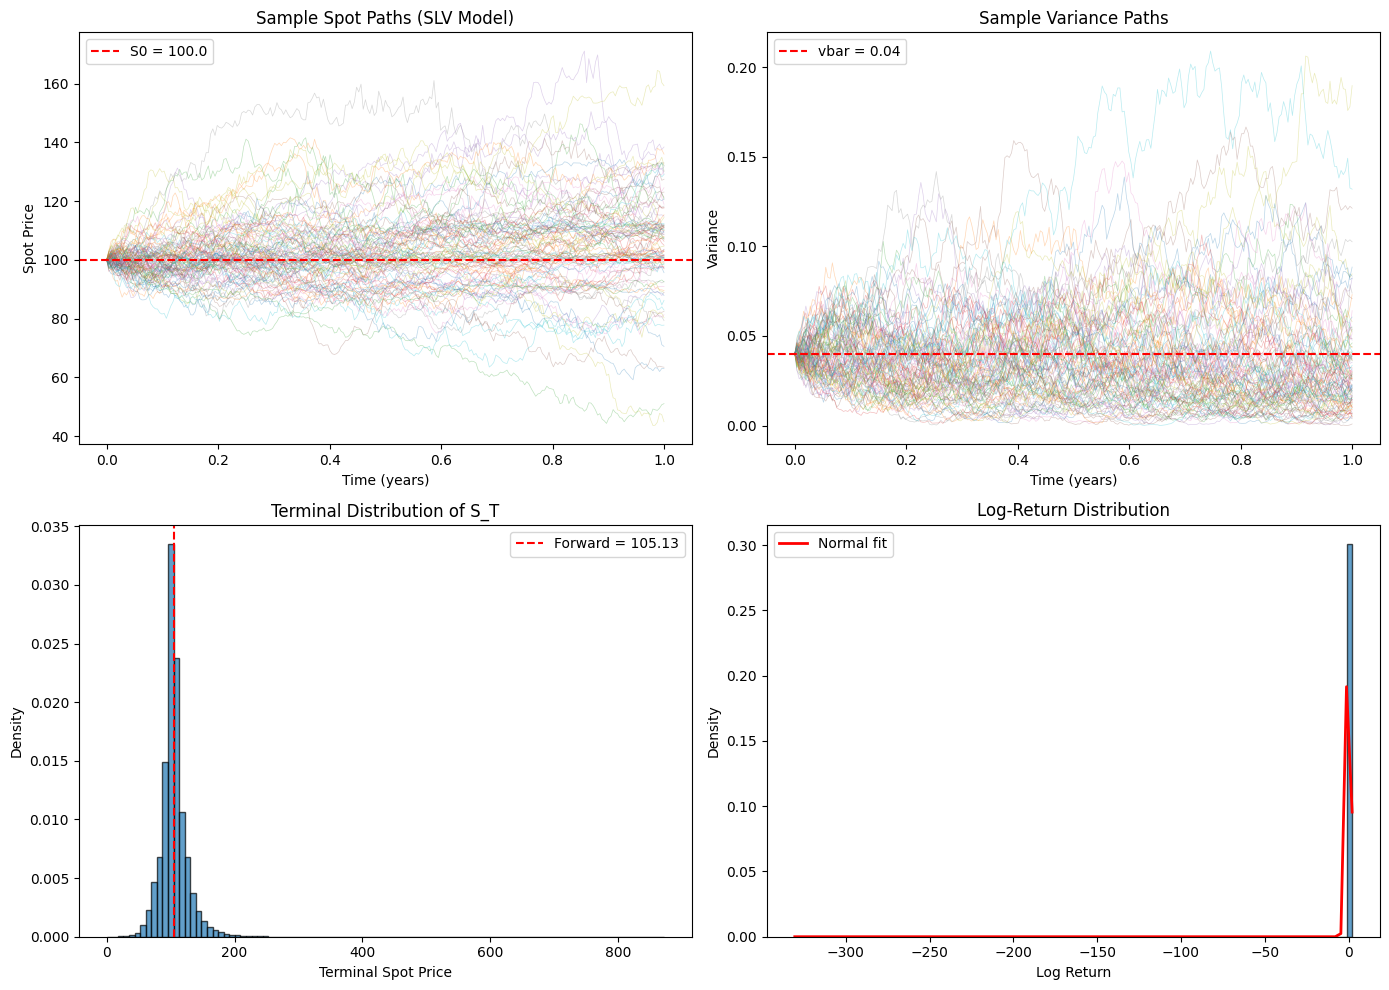


Log-return statistics:
  Skewness: -217.7145
  Kurtosis: 48247.9149


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot sample paths
ax = axes[0, 0]
t_grid = np.array(time_steps)
for i in range(min(100, n_paths_actual)):
    ax.plot(t_grid, spots[i, :], alpha=0.3, lw=0.5)
ax.axhline(S0, color='red', linestyle='--', label=f'S0 = {S0}')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Spot Price')
ax.set_title('Sample Spot Paths (SLV Model)')
ax.legend()

# Plot variance paths
ax = axes[0, 1]
for i in range(min(100, n_paths_actual)):
    ax.plot(t_grid, variances[i, :], alpha=0.3, lw=0.5)
ax.axhline(vbar, color='red', linestyle='--', label=f'vbar = {vbar}')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Variance')
ax.set_title('Sample Variance Paths')
ax.legend()

# Terminal distribution
ax = axes[1, 0]
ax.hist(spots[:, -1], bins=100, density=True, alpha=0.7, edgecolor='black')
ax.axvline(S0 * np.exp(r * T), color='red', linestyle='--', 
           label=f'Forward = {S0 * np.exp(r * T):.2f}')
ax.set_xlabel('Terminal Spot Price')
ax.set_ylabel('Density')
ax.set_title('Terminal Distribution of S_T')
ax.legend()

# Log-returns distribution
ax = axes[1, 1]
log_returns = np.log(spots[:, -1] / spots[:, 0])
ax.hist(log_returns, bins=100, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(log_returns.min(), log_returns.max(), 100)
ax.plot(x, stats.norm.pdf(x, log_returns.mean(), log_returns.std()), 
        'r-', lw=2, label='Normal fit')
ax.set_xlabel('Log Return')
ax.set_ylabel('Density')
ax.set_title('Log-Return Distribution')
ax.legend()

plt.tight_layout()
plt.show()

# Statistics
print(f"\nLog-return statistics:")
print(f"  Skewness: {stats.skew(log_returns):.4f}")
print(f"  Kurtosis: {stats.kurtosis(log_returns):.4f}")

## 6. Delta Hedging Analysis

Simulate delta hedging of a European call option.

In [9]:
# Option parameters
K = 100.0  # ATM strike

def delta_hedge_pnl(spots_path, times, K, r, vol_func):
    """Compute P&L from delta hedging a call option."""
    n = len(times)
    T = times[-1]
    
    # Initial position: short the option
    S0 = spots_path[0]
    vol0 = vol_func(S0, 0.0)
    option_price = cppfm.bs_call_price(S0, K, r, vol0, T)
    
    # Cash from selling option
    cash = option_price
    
    # Initial delta hedge
    delta = cppfm.bs_delta(S0, K, r, vol0, T, cppfm.OptionType.Call)
    shares = delta
    cash -= delta * S0
    
    # Rebalance at each time step
    for i in range(1, n):
        t = times[i]
        S = spots_path[i]
        tau = T - t  # time to maturity
        
        if tau <= 1e-6:
            # At maturity
            break
        
        # Interest accrual
        dt = times[i] - times[i-1]
        cash *= np.exp(r * dt)
        
        # New delta
        vol = vol_func(S, t)
        new_delta = cppfm.bs_delta(S, K, r, vol, tau, cppfm.OptionType.Call)
        
        # Rebalance
        trade = new_delta - shares
        cash -= trade * S
        shares = new_delta
    
    # Final settlement
    dt = times[-1] - times[-2]
    cash *= np.exp(r * dt)
    
    S_T = spots_path[-1]
    payoff = max(S_T - K, 0)
    
    # P&L = cash + stock value - option payoff
    pnl = cash + shares * S_T - payoff
    
    return pnl


# Hedging volatility function (using the vol surface)
def hedge_vol(S, t):
    # Use ATM implied vol for hedging (simple approach)
    try:
        return vol_surface.implied_volatility(K, max(T - t, 0.01))
    except:
        return 0.20  # fallback

In [10]:
# Compute hedging P&L for all paths
print("Computing hedging P&L for all paths...")

pnls = []
t_array = np.array(time_steps)

for i in range(n_paths_actual):
    pnl = delta_hedge_pnl(spots[i, :], t_array, K, r, hedge_vol)
    pnls.append(pnl)
    
    if (i + 1) % 10000 == 0:
        print(f"  Processed {i+1:,} / {n_paths_actual:,} paths")

pnls = np.array(pnls)
print(f"\nP&L Statistics:")
print(f"  Mean P&L:   {pnls.mean():.4f}")
print(f"  Std P&L:    {pnls.std():.4f}")
print(f"  Min P&L:    {pnls.min():.4f}")
print(f"  Max P&L:    {pnls.max():.4f}")
print(f"  Skewness:   {stats.skew(pnls):.4f}")
print(f"  Kurtosis:   {stats.kurtosis(pnls):.4f}")

Computing hedging P&L for all paths...
  Processed 10,000 / 50,000 paths
  Processed 20,000 / 50,000 paths
  Processed 30,000 / 50,000 paths
  Processed 40,000 / 50,000 paths
  Processed 50,000 / 50,000 paths

P&L Statistics:
  Mean P&L:   0.3725
  Std P&L:    3.6887
  Min P&L:    -518.0372
  Max P&L:    5.7764
  Skewness:   -96.0269
  Kurtosis:   12674.6286


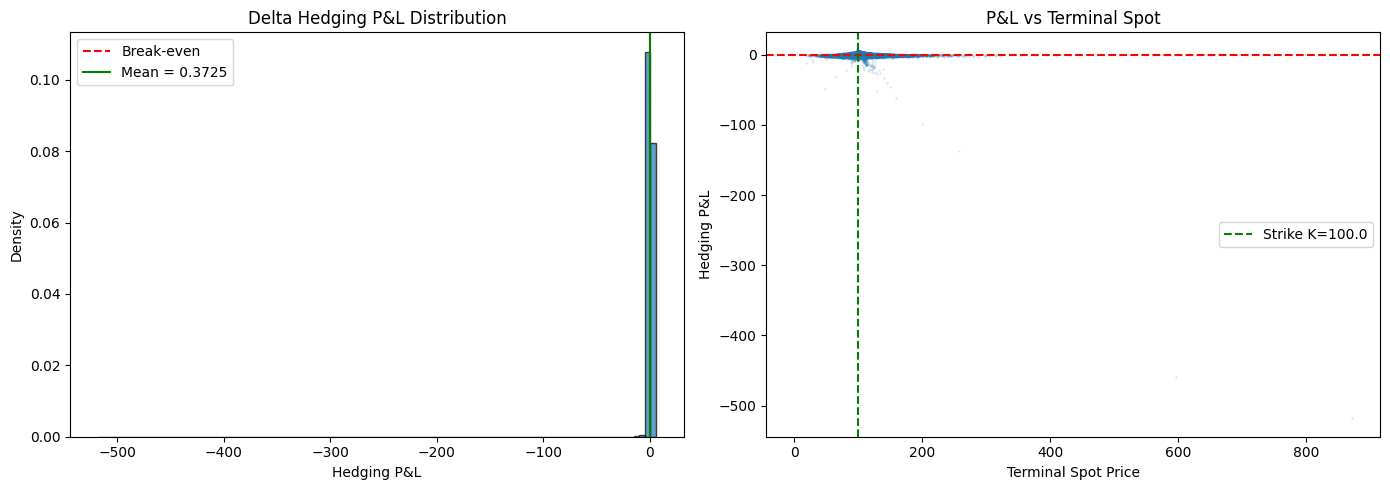

In [11]:
# Visualize P&L distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# P&L histogram
ax = axes[0]
ax.hist(pnls, bins=100, density=True, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', label='Break-even')
ax.axvline(pnls.mean(), color='green', linestyle='-', label=f'Mean = {pnls.mean():.4f}')
ax.set_xlabel('Hedging P&L')
ax.set_ylabel('Density')
ax.set_title('Delta Hedging P&L Distribution')
ax.legend()

# P&L vs terminal spot
ax = axes[1]
ax.scatter(spots[:, -1], pnls, alpha=0.1, s=1)
ax.axhline(0, color='red', linestyle='--')
ax.axvline(K, color='green', linestyle='--', label=f'Strike K={K}')
ax.set_xlabel('Terminal Spot Price')
ax.set_ylabel('Hedging P&L')
ax.set_title('P&L vs Terminal Spot')
ax.legend()

plt.tight_layout()
plt.show()

## 7. Greeks Analysis

Compute option Greeks using Black-Scholes formulas.

In [12]:
# Greeks for ATM option
atm_vol = vol_surface.implied_volatility(K, T)

print(f"ATM Call Option (K={K}, T={T}):")
print(f"  Implied Vol: {atm_vol:.2%}")
print(f"  Price:       {cppfm.bs_call_price(S0, K, r, atm_vol, T):.4f}")
print(f"  Delta:       {cppfm.bs_delta(S0, K, r, atm_vol, T, cppfm.OptionType.Call):.4f}")
print(f"  Gamma:       {cppfm.bs_gamma(S0, K, r, atm_vol, T):.4f}")
print(f"  Vega:        {cppfm.bs_vega(S0, K, r, atm_vol, T):.4f}")
print(f"  Theta:       {cppfm.bs_theta(S0, K, r, atm_vol, T, cppfm.OptionType.Call):.4f}")

ATM Call Option (K=100.0, T=1.0):
  Implied Vol: 18.00%
  Price:       9.7023
  Delta:       0.6435
  Gamma:       0.0207
  Vega:        37.2854
  Theta:       -6.0880


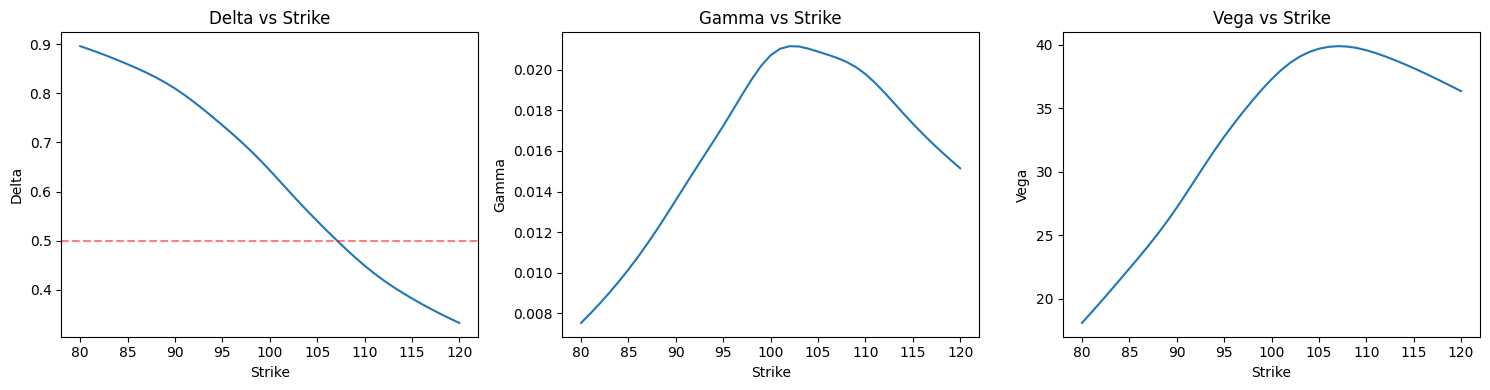

In [13]:
# Delta smile
strike_range = np.linspace(80, 120, 41)
deltas = []
gammas = []
vegas = []

for K_i in strike_range:
    vol_i = vol_surface.implied_volatility(K_i, T)
    deltas.append(cppfm.bs_delta(S0, K_i, r, vol_i, T, cppfm.OptionType.Call))
    gammas.append(cppfm.bs_gamma(S0, K_i, r, vol_i, T))
    vegas.append(cppfm.bs_vega(S0, K_i, r, vol_i, T))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(strike_range, deltas)
axes[0].axhline(0.5, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Delta')
axes[0].set_title('Delta vs Strike')

axes[1].plot(strike_range, gammas)
axes[1].set_xlabel('Strike')
axes[1].set_ylabel('Gamma')
axes[1].set_title('Gamma vs Strike')

axes[2].plot(strike_range, vegas)
axes[2].set_xlabel('Strike')
axes[2].set_ylabel('Vega')
axes[2].set_title('Vega vs Strike')

plt.tight_layout()
plt.show()

## 8. Implied Volatility Surface Visualization

In [14]:
# Create grid for surface plot
K_grid = np.linspace(82, 118, 50)
T_grid = np.linspace(0.1, 1.8, 50)

IV_surface = np.zeros((len(T_grid), len(K_grid)))
LV_surface = np.zeros((len(T_grid), len(K_grid)))

for i, t in enumerate(T_grid):
    for j, k in enumerate(K_grid):
        try:
            IV_surface[i, j] = vol_surface.implied_volatility(k, t)
            LV_surface[i, j] = vol_surface.local_volatility(k, t)
        except:
            IV_surface[i, j] = np.nan
            LV_surface[i, j] = np.nan

K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)
print(f"Grid created: {K_mesh.shape}")

Grid created: (50, 50)


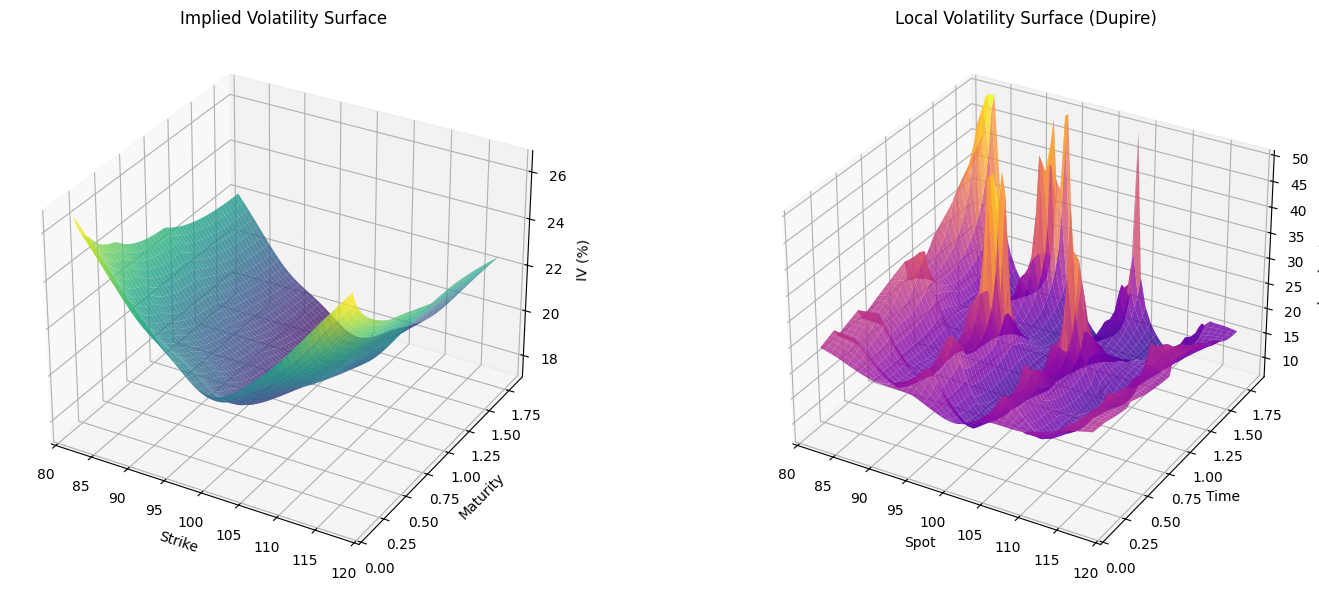

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# Implied volatility surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(K_mesh, T_mesh, IV_surface * 100, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('IV (%)')
ax1.set_title('Implied Volatility Surface')

# Local volatility surface
ax2 = fig.add_subplot(122, projection='3d')
# Clip extreme values
LV_clipped = np.clip(LV_surface * 100, 0, 50)
ax2.plot_surface(K_mesh, T_mesh, LV_clipped, cmap='plasma', alpha=0.8)
ax2.set_xlabel('Spot')
ax2.set_ylabel('Time')
ax2.set_zlabel('Local Vol (%)')
ax2.set_title('Local Volatility Surface (Dupire)')

plt.tight_layout()
plt.show()

- Where do the "blow-ups" come from? From denominator in the formula - gets small, local vol blow-up. Butterfly spread - measuring density of the risk-neutral distribution. 
    - if IV surface has butterfly or calendar spread arbitrage, the local vol can go negative or infinite (but we clip extreme values)

- Strike boundaries - extreme strikes (far OTM), option prices are nearly zero, and the second derivative becomes tiny/noisy
- Short maturities - the distribution is more peaked, making derivatives unstable
- interpolation artifacts - cubic spline interpolation on IV can introduce wiggles that cause ∂2C/∂2K to oscillate near zero

What does the HestonSLV do?
Intuition:
- If Heston's variance is too high in some region -> L < 1 dampens it
- If Heston's variance is too low -> L > 1 amplifies it
- The result: paths have Heston-like stochastic vol dynamics but produce a terminal distribution matching the market-implied surface


TODO: Make a plot to show HestonSLV matching the vol smile

TODO: Add SVI
    - Cubic spline: exact fit, but possibly unstable derivatives
    - SVI: approximate fit (at the expense of small errors), but guaranteed stable derivatives [that matters more than exact fit] - it gives a stable local vol surface